# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = ASIA_FX + G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
corp_spread = pd.read_csv("../../Dymon/Code Data/spread.csv", index_col=0).iloc[2:]
corp_spread = corp_spread.astype(float)
corp_spread.index = pd.to_datetime(corp_spread.index)

# Data integrity

In [5]:
corp_spread.pipe(fill_date).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5644 entries, 2000-01-03 to 2021-08-19
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LGCPOAS Index  5355 non-null   float64
 1   LG50OAS Index  3023 non-null   float64
dtypes: float64(2)
memory usage: 132.3 KB


<AxesSubplot:>

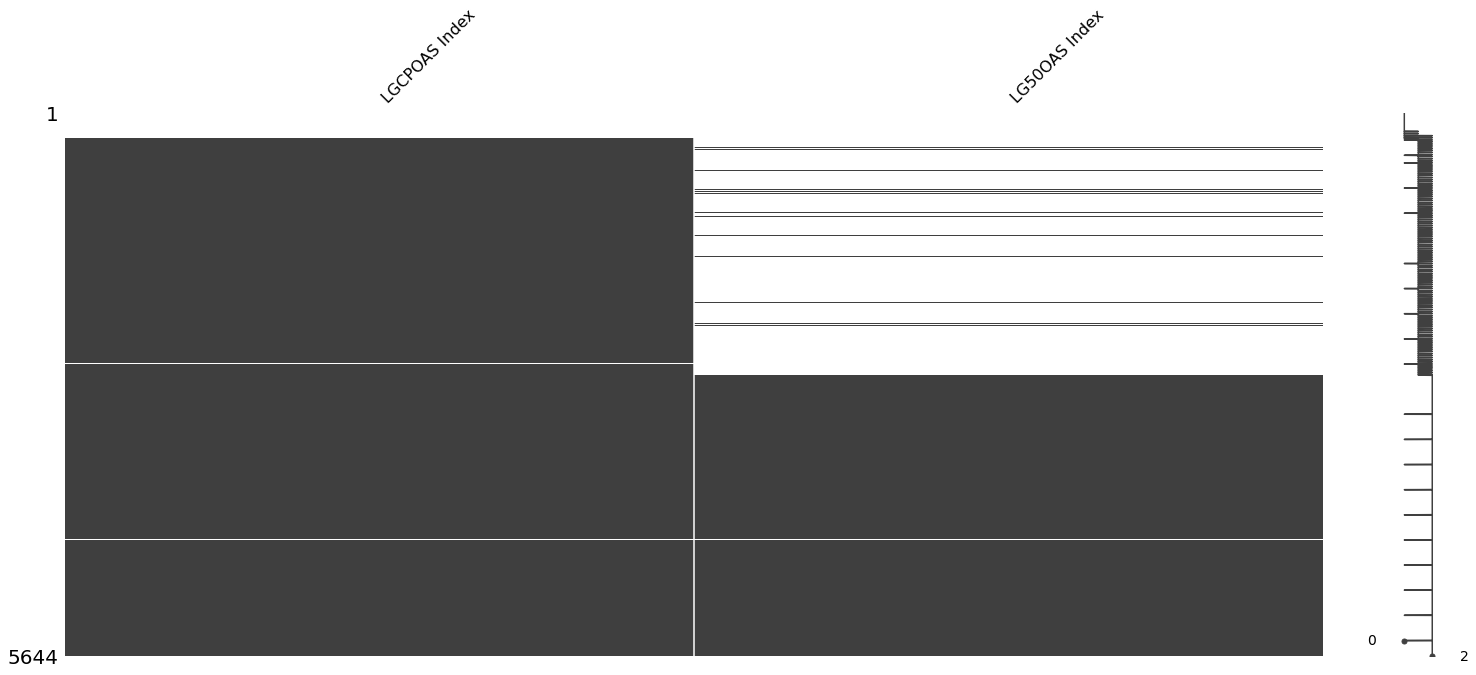

In [6]:
msmx(corp_spread.pipe(fill_date))

# Signal

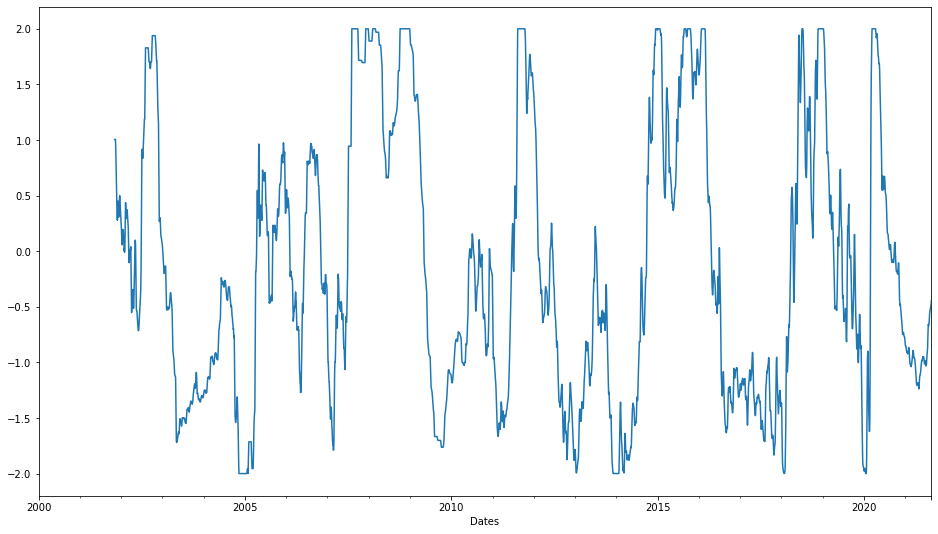

In [7]:
## IG clean data
ig_signal = corp_spread[["LGCPOAS Index"]].pipe(fill_date, True).pipe(omit_trailing_na).pipe(zscore, 252, typ="median").pipe(cap_helper, 2).pipe(omit_leading_na)

### stitch LG50OAS --> started out monthly
beginning = corp_spread[["LG50OAS Index"]].pipe(omit_leading_na).loc[:"2011-05-31"]
monthly_data = beginning.groupby(beginning.index.strftime("%Y-%m")).last()
monthly_data.index = [x[-1] for x in beginning.index.groupby(beginning.index.strftime("%Y-%m")).values()]

monthly_zscore = monthly_data.pipe(zscore, 12).pipe(cap_helper, 2).pipe(omit_leading_na)
daily_zscore = corp_spread[["LG50OAS Index"]].loc["2010-06-15":].pipe(fill_date, True).pipe(omit_leading_na).pipe(zscore, 252).pipe(cap_helper, 2).pipe(omit_leading_na).pipe(omit_trailing_na)
hy_signal = pd.concat([monthly_zscore, daily_zscore]).pipe(fill_date, True)


signal = (ig_signal["LGCPOAS Index"] + hy_signal["LG50OAS Index"])/2
signal = signal.pipe(rolling_mean, 5)
signal.plot()
sig = pd.concat([signal] * len(total_returns.columns), axis=1)
sig.columns = total_returns.columns
sig.index = pd.to_datetime(sig.index)

# Backtest Daily Rebal

In [8]:
daily_bt = Backtest(signal = sig, 
                    asset_returns = total_returns, 
                    tcost = abs(total_returns*0), 
                    settings = settings, 
                    asset_groups={"ASIA":ASIA_FX, "G10":G10_FX})
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]


In [9]:
get_summary(daily_bt)

Returns   : 0.07839671820693797
Vol       : 0.10551677790856885
SR        : 0.7429786974244927
Max DD    : -23.48

C Returns : 0.07553910782817837
C SR      : 0.5284665430286556
C Max DD  : -21.15

Hit rate  : 0.521
W | N | L : 0.52 | 0.0 | 0.48
W/L Ratio : 1.09


In [10]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR,USDMYR,USDCNH,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,0.368243,0.614921,0.502864,0.864009,-0.039993,0.727836,0.3394,0.519529,1.322529,0.498336,0.382559,0.396532,0.644277,-0.201647,0.50817,0.449202,0.593083,0.273652
sharpe,0.350198,0.52042,0.419012,0.744726,-0.03572,0.6379,0.284575,0.475782,0.971363,0.54198,0.418488,0.456287,0.743563,-0.217026,0.570331,0.509379,0.691472,0.245396
dollar_sharpe,0.343057,0.506238,0.407691,0.727372,-0.040707,0.627828,0.279685,0.469152,0.95478,0.526084,0.405961,0.445281,0.729277,-0.216654,0.558796,0.496672,0.678733,0.233052
trade_sharpe,0.350198,0.52042,0.419012,0.744726,-0.03572,0.6379,0.284575,0.475782,0.971363,0.54198,0.418488,0.456287,0.743563,-0.217026,0.570331,0.509379,0.691472,0.245396
long_sharpe,0.163987,-0.719591,0.668475,0.54756,-0.566395,0.167527,0.014109,0.689962,0.586673,0.438479,0.511156,0.421221,0.87402,-0.343816,0.37819,0.620907,0.796666,-0.037317
short_sharpe,0.452178,1.022805,0.308193,0.865663,0.256702,0.933809,0.449269,0.348089,1.347471,0.608823,0.368808,0.477181,0.667463,-0.141391,0.692019,0.45,0.629614,0.524529
sortino,0.225512,0.31795,0.273409,0.457849,-0.021945,0.393407,0.162296,0.291057,0.845502,0.359264,0.27762,0.312888,0.508248,-0.131042,0.393042,0.357498,0.474832,0.117002
max_drawdown,-2.81287,-3.980998,-3.460346,-2.715503,-4.858892,-4.304292,-3.290446,-1.919752,-2.689675,-2.282875,-3.468602,-2.813746,-1.575438,-6.824625,-1.632712,-1.817079,-1.835891,-2.672207
max_drawdown_start,2004-12-01,2007-01-26,2012-11-12,2005-10-21,2005-03-16,2005-12-05,2004-01-12,2006-05-10,2014-01-20,2011-10-03,2012-09-13,2009-10-22,2009-08-05,2007-03-05,2005-12-27,2015-08-07,2007-08-16,2015-01-13
max_drawdown_end,2008-04-22,2008-03-20,2014-03-20,2006-03-09,2016-11-24,2006-11-15,2007-06-08,2008-04-23,2014-04-29,2014-01-24,2014-03-20,2011-01-07,2010-11-30,2016-12-15,2007-03-05,2016-12-15,2008-04-22,2015-01-15


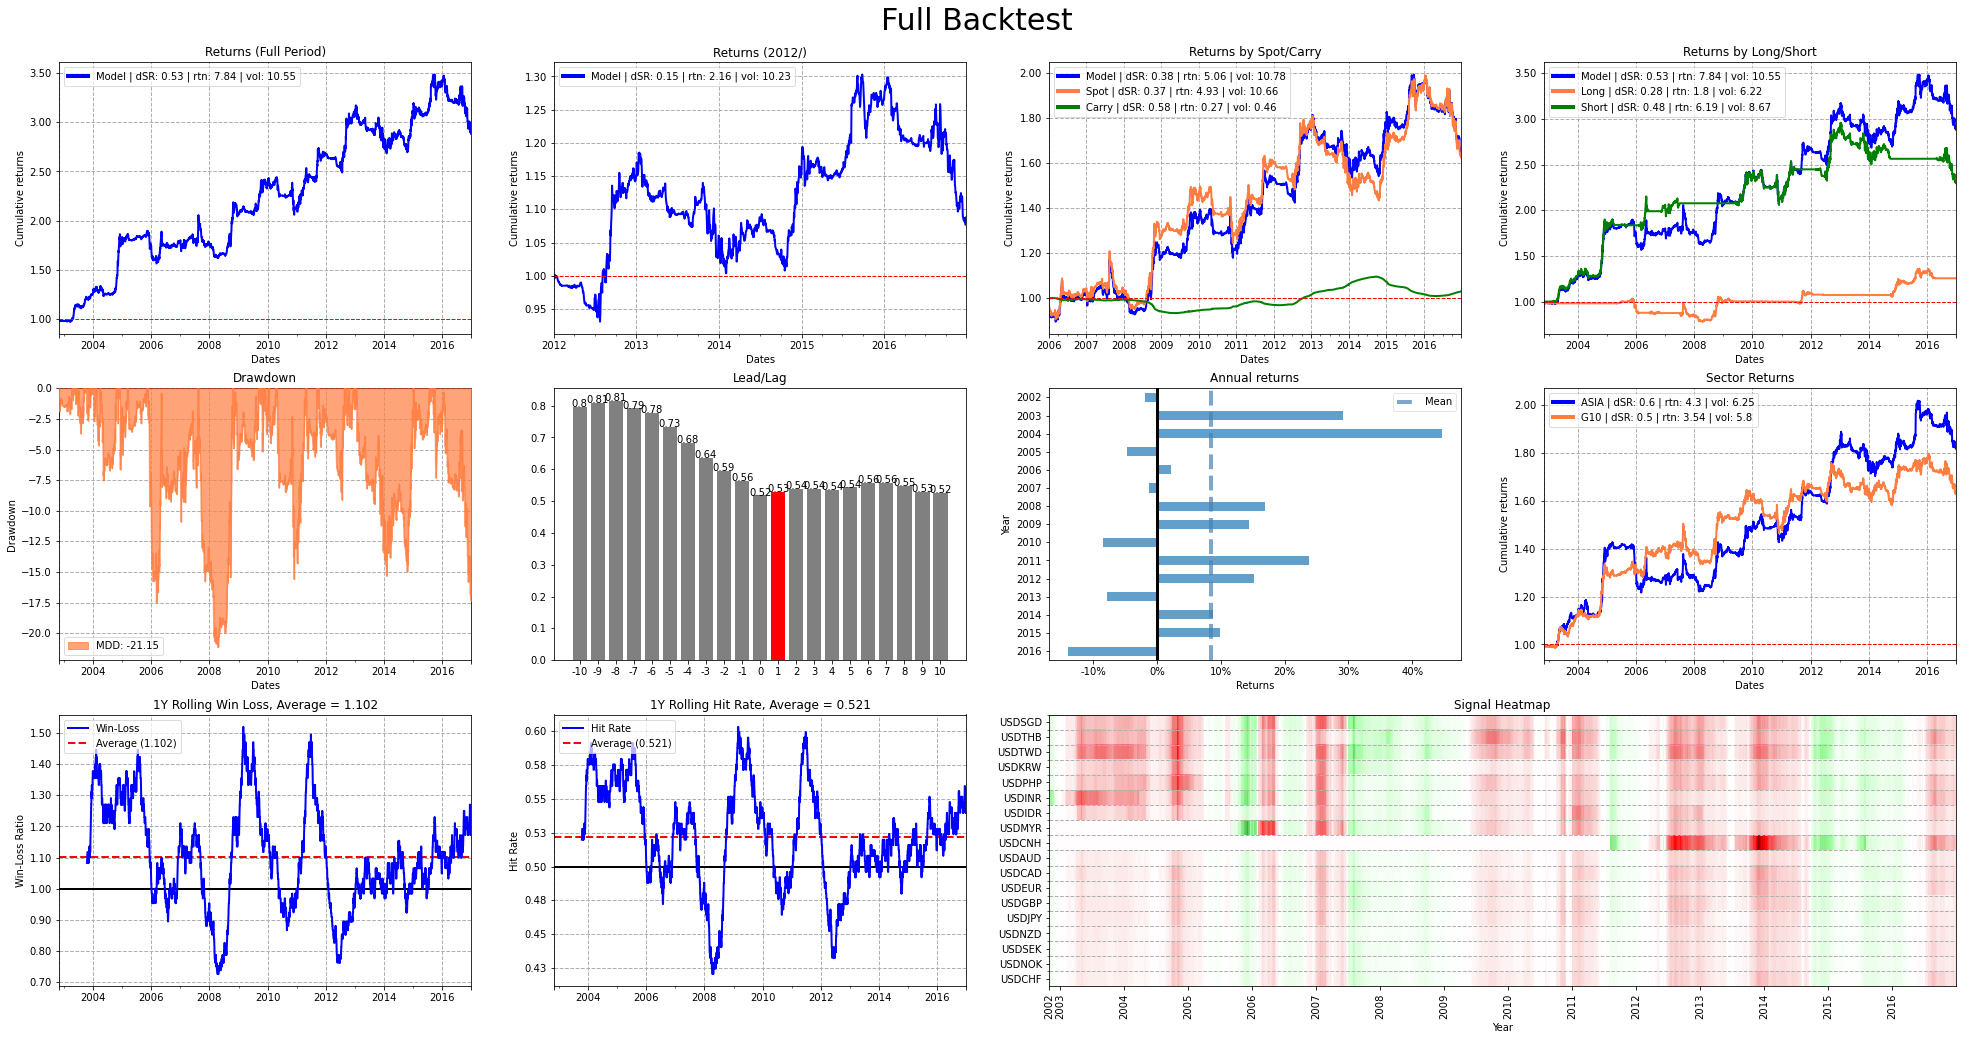

In [11]:
plot_bt2(daily_bt)

# Backtest Weekly Rebal

In [12]:
weekly_bt = Backtest(signal = sig, 
             asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = settings,
             settings_inject = {"rebalance_period":"friday"},
             asset_groups={"ASIA":ASIA_FX, "G10":G10_FX})
weekly_bt.run()

Re-arranging asset columns
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]


In [13]:
get_summary(weekly_bt)

Returns   : 0.07781620846431828
Vol       : 0.10756760403279145
SR        : 0.7234167681246892
Max DD    : -24.52

C Returns : 0.07467976424846981
C SR      : 0.5110948500134711
C Max DD  : -21.99

Hit rate  : 0.523
W | N | L : 0.52 | 0.0 | 0.48
W/L Ratio : 1.1


In [14]:
get_returns_stats(weekly_bt.asset_rtn, weekly_bt.wts)

,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR,USDMYR,USDCNH,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,0.359754,0.648443,0.43926,0.88457,-0.062479,0.745852,0.28402,0.510812,1.365501,0.511376,0.339349,0.401993,0.644926,-0.2339,0.51876,0.448229,0.64349,0.248016
sharpe,0.338515,0.538425,0.363908,0.719895,-0.054586,0.633702,0.218897,0.455297,0.998442,0.537491,0.363501,0.459651,0.739011,-0.243963,0.571188,0.501039,0.737719,0.21909
dollar_sharpe,0.330899,0.522961,0.353022,0.700446,-0.059404,0.623659,0.213193,0.451428,0.981806,0.521746,0.352772,0.448673,0.72316,-0.243306,0.558863,0.488629,0.724134,0.207339
trade_sharpe,0.338515,0.538425,0.363908,0.719895,-0.054586,0.633702,0.218897,0.455297,0.998442,0.537491,0.363501,0.459651,0.739011,-0.243963,0.571188,0.501039,0.737719,0.21909
long_sharpe,0.137451,-0.661159,0.61333,0.505529,-0.591466,0.222638,0.003228,0.750532,0.667539,0.478288,0.490302,0.442284,0.903945,-0.380431,0.406926,0.642138,0.844482,-0.080675
short_sharpe,0.449286,1.022632,0.244843,0.858401,0.235213,0.894284,0.369521,0.287463,1.320155,0.577371,0.294012,0.470647,0.642885,-0.162285,0.676265,0.425888,0.67527,0.516843
sortino,0.214323,0.331343,0.227361,0.439463,-0.033525,0.385438,0.120671,0.273465,0.837544,0.362226,0.23957,0.317673,0.507449,-0.147051,0.395686,0.352601,0.51023,0.103549
max_drawdown,-2.897096,-3.898603,-3.511407,-2.583862,-4.889571,-4.504524,-3.261443,-2.236123,-2.808127,-2.413661,-3.378688,-2.903998,-1.789628,-6.997817,-1.612697,-1.783518,-1.90507,-2.884411
max_drawdown_start,2004-12-01,2007-01-26,2012-11-12,2005-07-06,2005-03-16,2005-12-05,2004-01-12,2006-05-10,2014-01-20,2011-10-03,2012-09-13,2009-10-22,2009-08-05,2007-03-05,2005-12-27,2015-08-07,2007-08-16,2014-03-14
max_drawdown_end,2008-04-22,2008-03-20,2014-03-20,2007-03-05,2016-11-24,2006-11-15,2007-03-05,2008-04-23,2014-04-29,2014-01-24,2014-03-20,2010-11-30,2010-11-30,2016-12-15,2007-03-05,2016-12-15,2008-04-22,2016-12-15


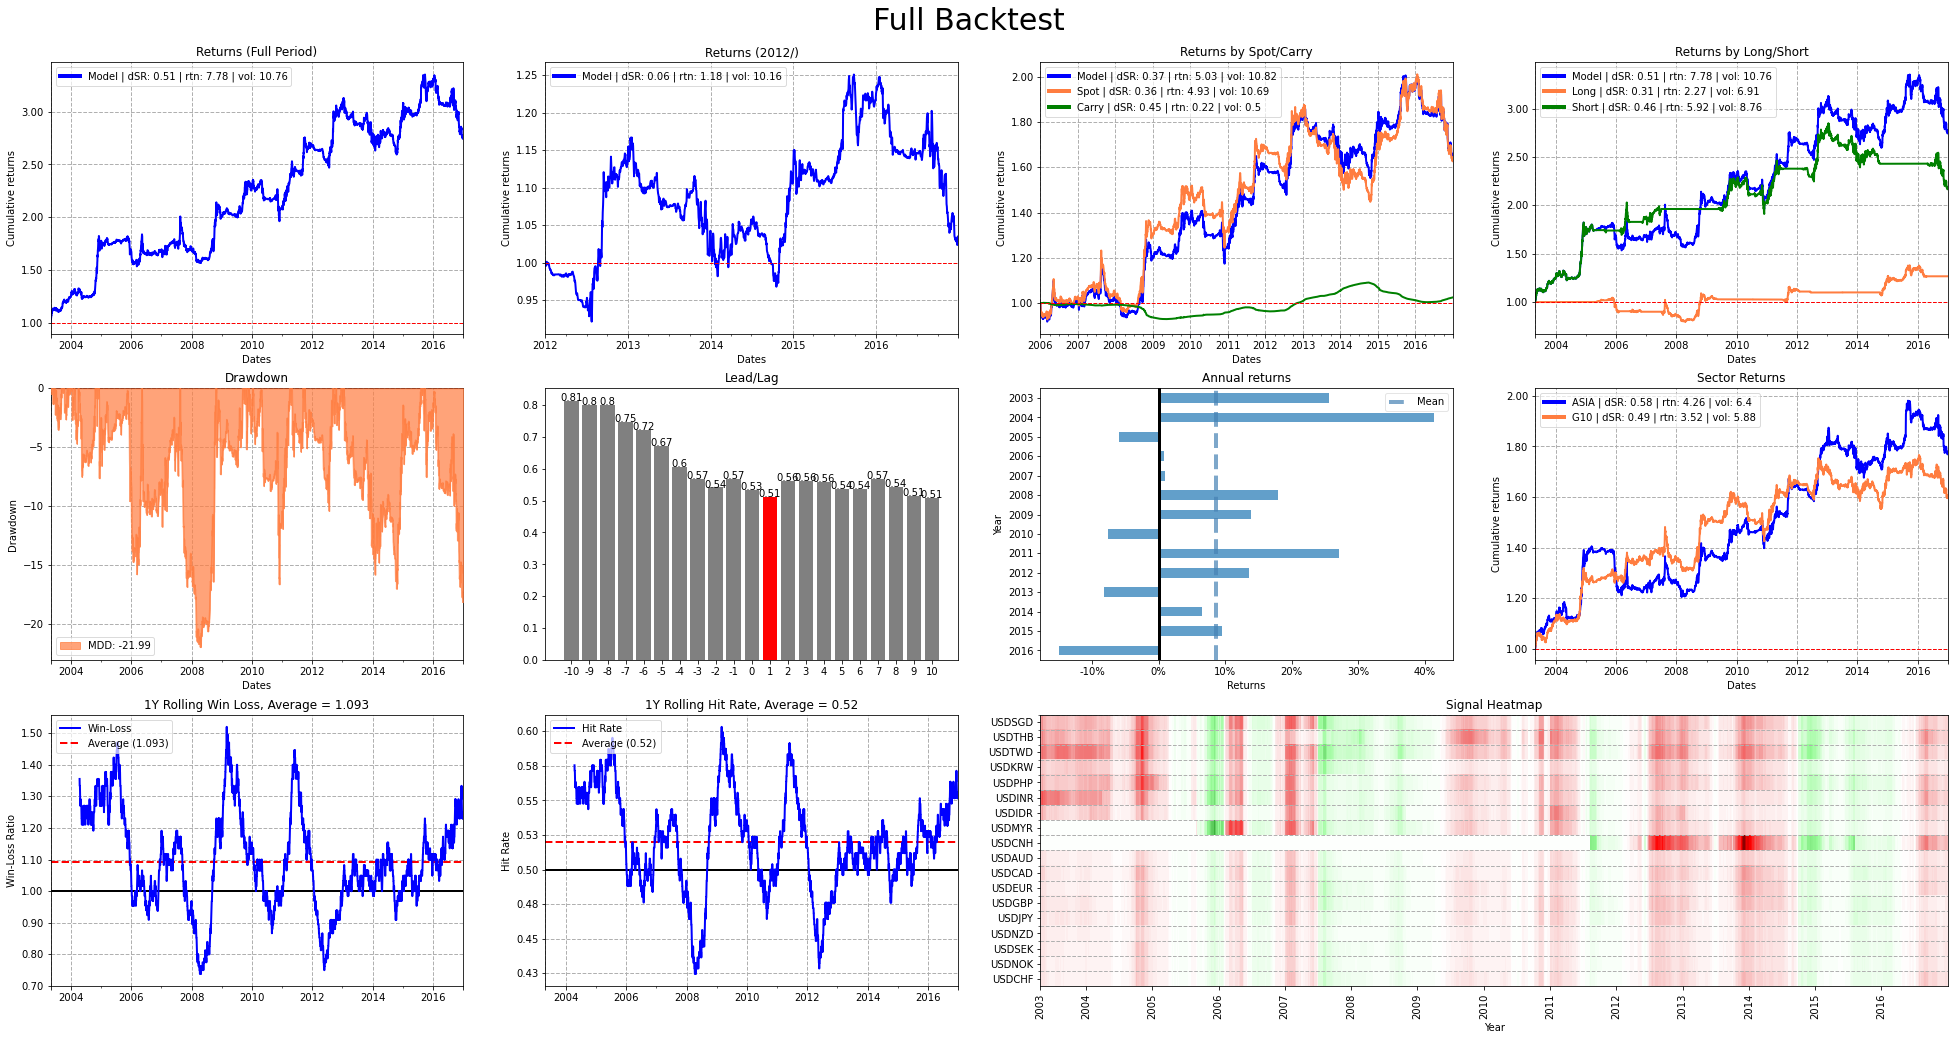

In [15]:
plot_bt2(weekly_bt)

# Daily vs Weekly 

<AxesSubplot:title={'center':'Daily vs Weekly Rebal'}, xlabel='Dates', ylabel='Cumulative returns'>

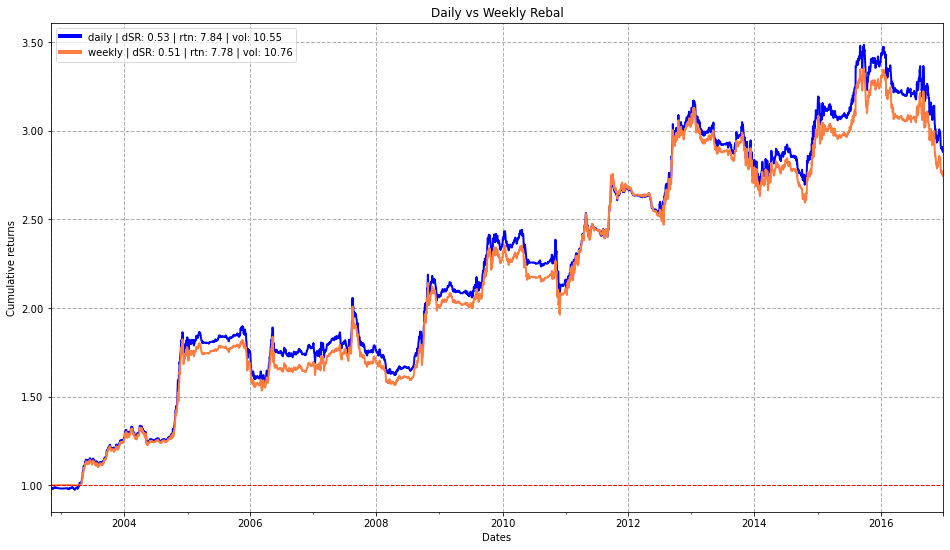

In [16]:
gen_plot_rtn(pd.concat([daily_bt.model_rtn.rename("daily"), weekly_bt.model_rtn.rename("weekly")], axis=1), main = "Daily vs Weekly Rebal")

In [17]:
# pickle.dump(daily_bt, open("../BT/carry_unwinding_credit_daily.p", "wb"))
# daily_bt = pickle.load(open("../BT/carry_unwinding_credit_daily.p", "rb"))

# pickle.dump(weekly_bt, open("../BT/carry_unwinding_credit_weekly.p", "wb"))
# weekly_bt = pickle.load(open("../BT/carry_unwinding_credit_weekly.p", "rb"))

# Regime Plot

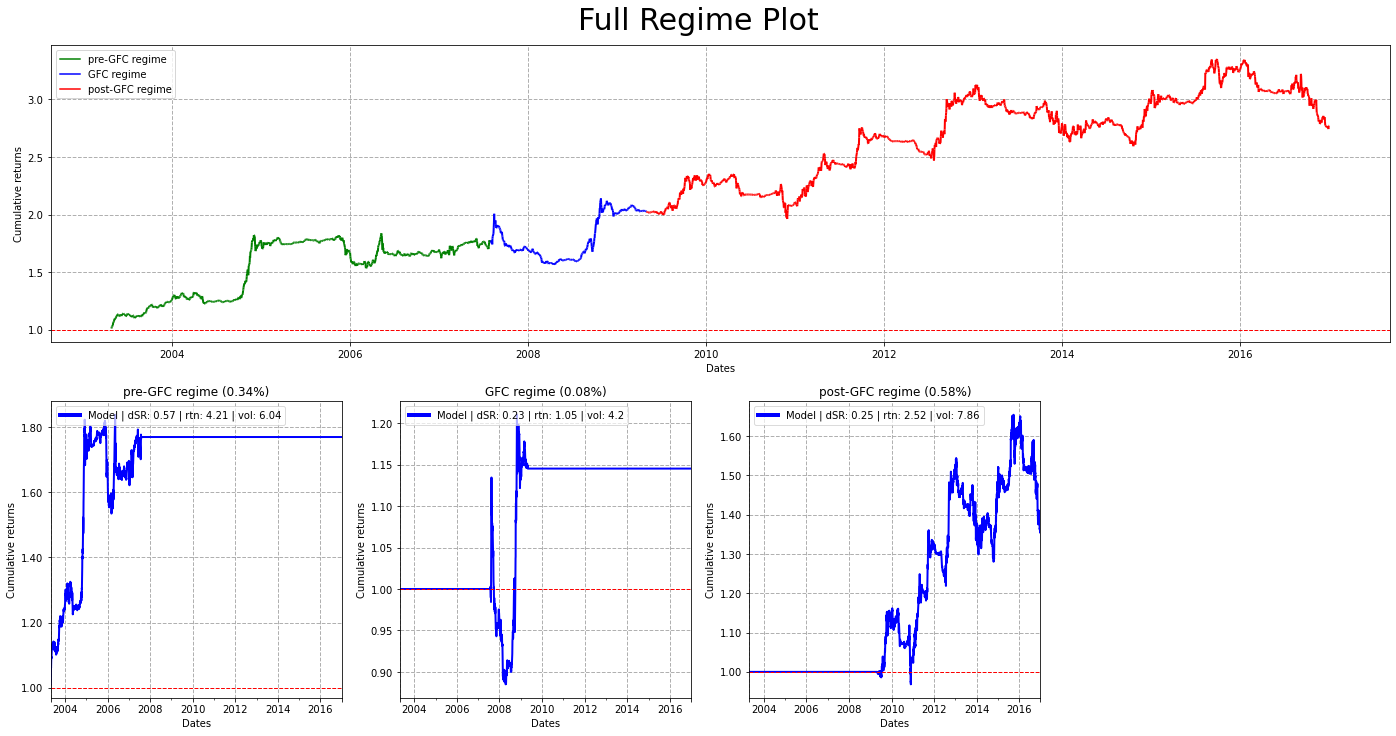

In [18]:
full_regime_plot(weekly_bt, gfc_regime)

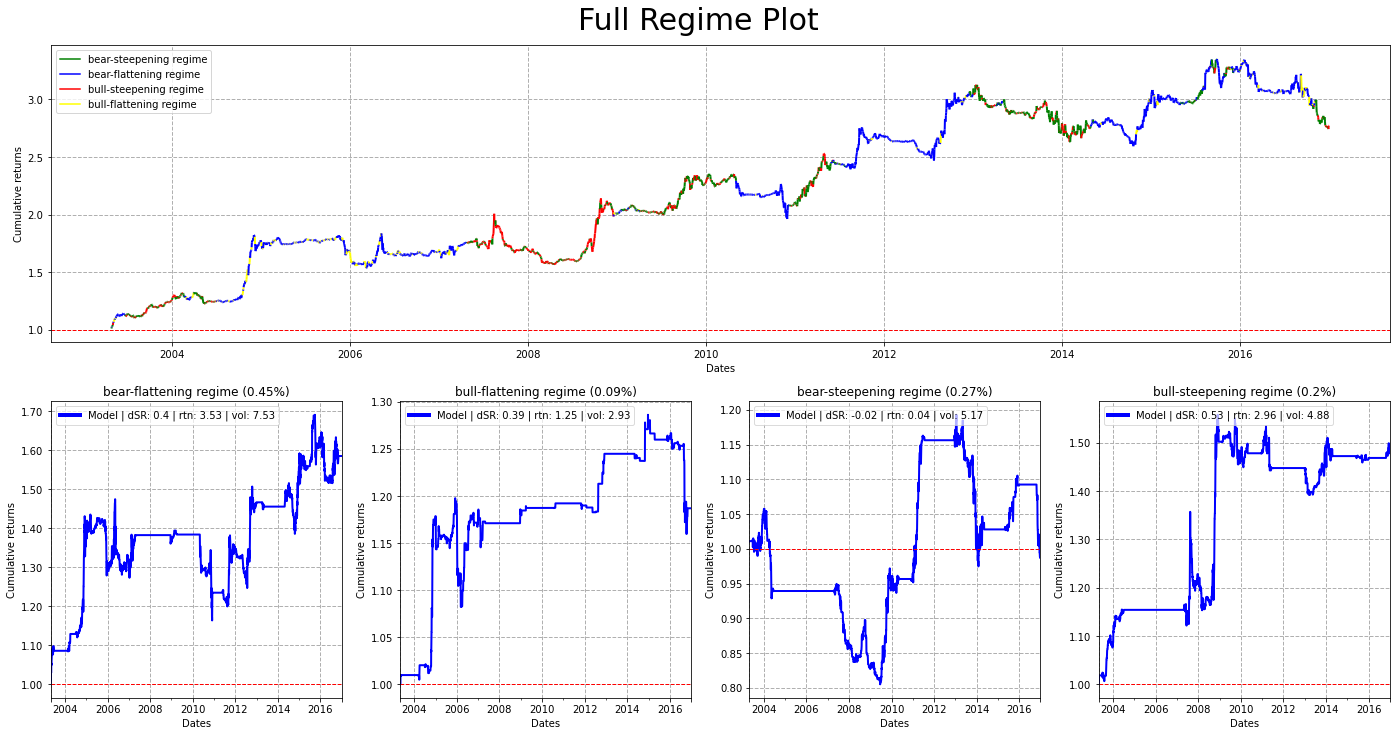

In [19]:
full_regime_plot(weekly_bt, rates_regime)

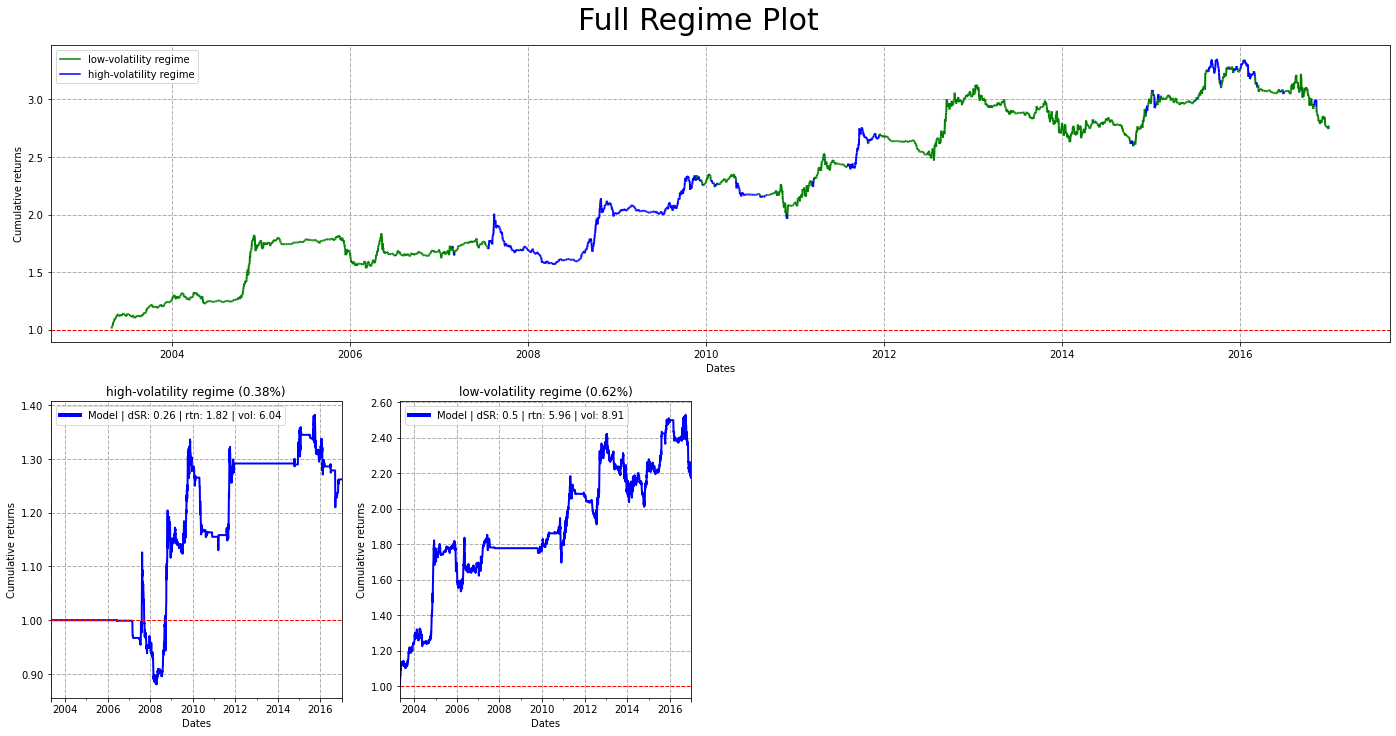

In [20]:
full_regime_plot(weekly_bt, vol_regime)

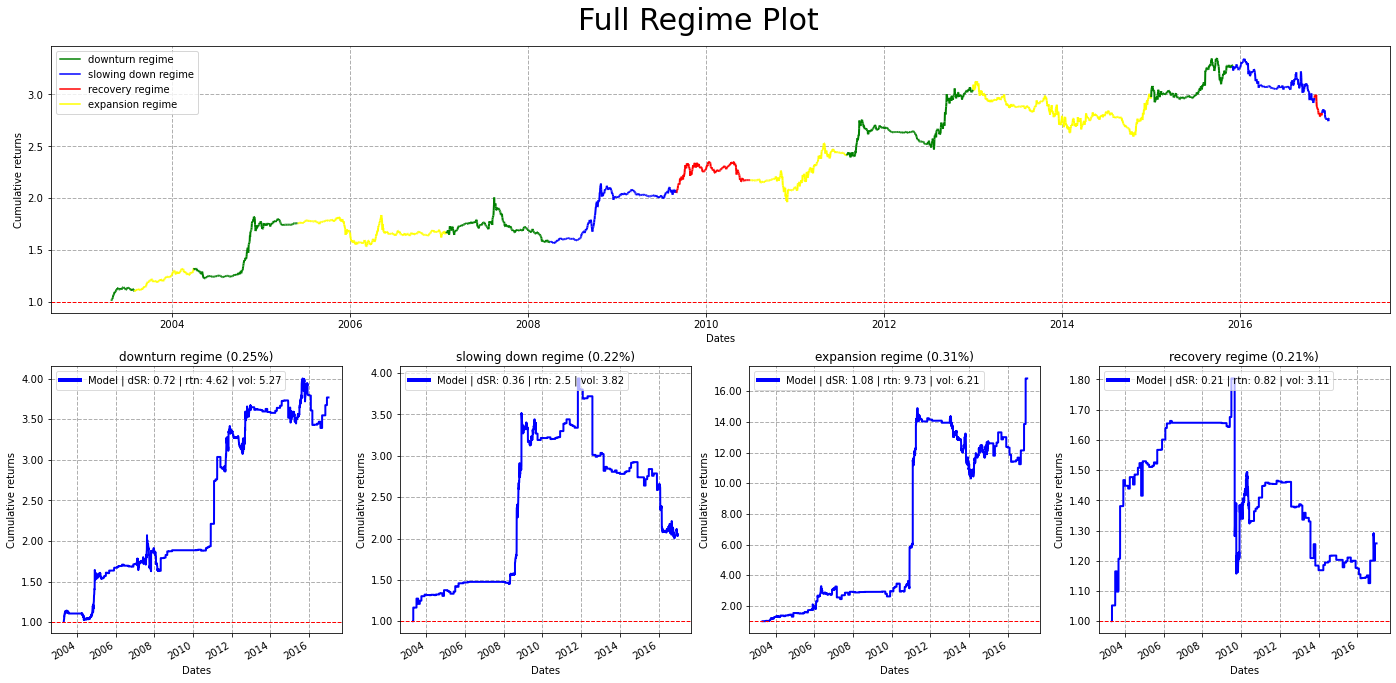

In [21]:
full_regime_plot(weekly_bt, cycle_regime)

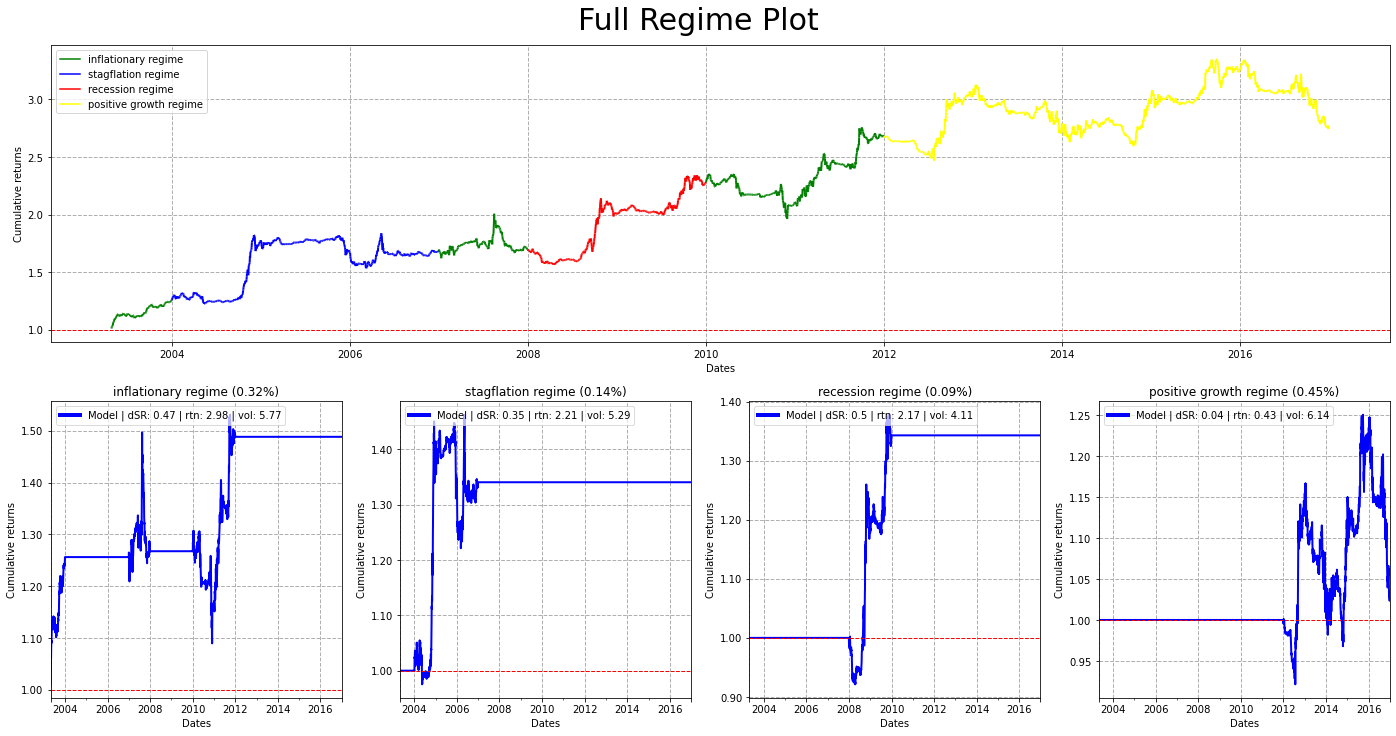

In [22]:
full_regime_plot(weekly_bt, macro_regime)

# Sensitivity Analysis

In [23]:
def signal_generation(lookback):
    ig_signal = corp_spread[["LGCPOAS Index"]].pipe(fill_date, True).pipe(omit_trailing_na).pipe(zscore, int(lookback*252), typ="median").pipe(cap_helper, 2).pipe(omit_leading_na)
    beginning = corp_spread[["LG50OAS Index"]].pipe(omit_leading_na).loc[:"2011-05-31"]
    monthly_data = beginning.groupby(beginning.index.strftime("%Y-%m")).last()
    monthly_data.index = [x[-1] for x in beginning.index.groupby(beginning.index.strftime("%Y-%m")).values()]

    monthly_zscore = monthly_data.pipe(zscore, int(lookback*12)).pipe(cap_helper, 2).pipe(omit_leading_na)
    daily_zscore = corp_spread[["LG50OAS Index"]].loc["2010-06-15":].pipe(fill_date, True).pipe(omit_leading_na).pipe(zscore, int(lookback*252)).pipe(cap_helper, 2).pipe(omit_leading_na).pipe(omit_trailing_na)
    hy_signal = pd.concat([monthly_zscore.loc[:daily_zscore.index[0]], daily_zscore]).pipe(fill_date, True)
    
    signal = (ig_signal["LGCPOAS Index"] + hy_signal["LG50OAS Index"])/2
    signal = signal.pipe(rolling_mean, 5)
    sig = pd.concat([signal] * len(total_returns.columns), axis=1)
    sig.columns = total_returns.columns
    sig.index = pd.to_datetime(sig.index)
    
    return sig

In [24]:
signalsa = [signal_generation(i) for i in [0.25,0.5,1,2,3,4,5]] 
# signalsa

In [25]:
backtestsa = [Backtest(signal = x, 
                    asset_returns = total_returns, 
                    tcost = abs(total_returns*0), 
                    settings = settings, 
                    asset_groups={"ASIA":ASIA_FX, "G10":G10_FX}) for x in signalsa]

for testsa in backtestsa:
    testsa.run()

Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]


<AxesSubplot:xlabel='Dates', ylabel='Cumulative returns'>

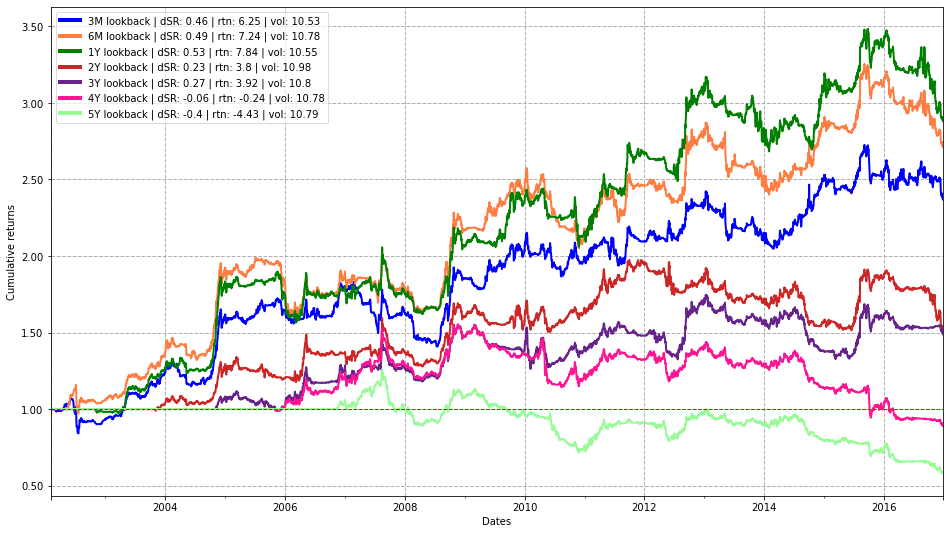

In [26]:
sa_variants = pd.DataFrame([x.model_rtn for x  in backtestsa]).T
sa_variants.columns = ["3M lookback", "6M lookback", "1Y lookback", "2Y lookback","3Y lookback","4Y lookback","5Y lookback"]
gen_plot_rtn(sa_variants)